In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp_data = calc_temps("2016-08-01", "2016-08-08")

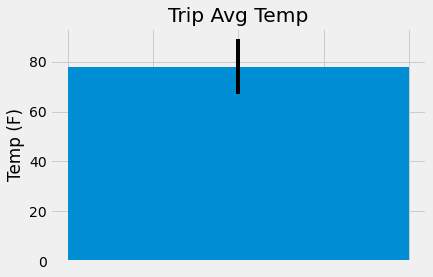

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(0,height=temp_data[0][1], yerr=(temp_data[0][2] - temp_data[0][0]), align="center", width=0.4)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start = "2016-08-01"
end = "2016-08-08"
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
    filter(Measurement.date >= start, Measurement.date <= end).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by((Measurement.prcp).desc()).all()


[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.53),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.35),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.21),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.54),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  None)]

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime.strptime(start, "%Y-%m-%d")
end_date = dt.datetime.strptime(end, "%Y-%m-%d")

# Use the start and end date to create a range of dates
trip_dates = pd.date_range("2017-08-01", "2017-08-07")
trip_dates = []
delta = end_date - start_date       # as timedelta

for i in range(delta.days + 1):
    day = start_date + dt.timedelta(days=i)
    trip_dates.append(day)
    print(day)

# Strip off the year and save a list of strings in the format %m-%d
month_date_dt = []
for n in trip_dates:
    month_day_strip = n.strftime("%m-%d")
    month_date_dt.append(month_day_strip)

    # Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for i in range(len(month_date_dt)):
    daily_norms = daily_normals(month_date_dt[i])
    normals.append(daily_norms)
normals

2016-08-01 00:00:00
2016-08-02 00:00:00
2016-08-03 00:00:00
2016-08-04 00:00:00
2016-08-05 00:00:00
2016-08-06 00:00:00
2016-08-07 00:00:00
2016-08-08 00:00:00


[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(68.0, 76.5576923076923, 83.0)]]

In [15]:
y_m_d = []
for n in trip_dates:
    y_m_d_strip = n.strftime("%Y-%m-%d")
    y_m_d.append(y_m_d_strip)
y_m_d

['2016-08-01',
 '2016-08-02',
 '2016-08-03',
 '2016-08-04',
 '2016-08-05',
 '2016-08-06',
 '2016-08-07',
 '2016-08-08']

In [16]:
t_min = []
t_avg = []
t_max = []
for i in range(len(normals)):
    min_temp = normals[i][0][0]
    avg_temp = normals[i][0][1]
    max_temp = normals[i][0][2]
    t_min.append(min_temp)
    t_avg.append(avg_temp)
    t_max.append(max_temp)

In [17]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame({"Min Temp": t_min, 
                   "Avg Temp": t_avg,
                   "Max Temp": t_max}, index=y_m_d)
df.index.name = "date"
df

,Min Temp,Avg Temp,Max Temp
date,,,
2016-08-01,67.0,75.540000,83.0
2016-08-02,68.0,75.603774,84.0
2016-08-03,70.0,76.611111,85.0
2016-08-04,69.0,76.711538,84.0
2016-08-05,69.0,76.148148,82.0
2016-08-06,67.0,76.250000,83.0
2016-08-07,71.0,77.156863,83.0
2016-08-08,68.0,76.557692,83.0


Text(0, 0.5, 'Temperature')

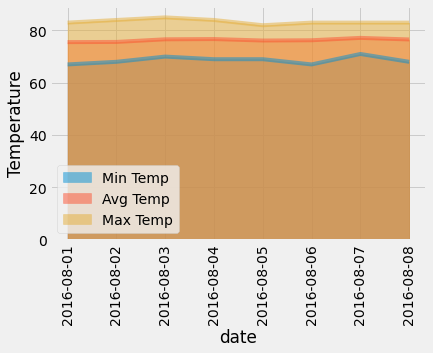

In [18]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False, rot=90)
plt.ylabel("Temperature")

## Close Session

In [19]:
session.close()